In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["palestinianlivesmatter",
                 "israelterrorist""israelterrorists","save_sheikh_jarrah"])

In [3]:
# Read data
df = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/omdena-colombia-socialnetwork/Untitled/src/data/task-2-preprocessing/merged_data/Final/Final_all.csv')
df.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,preprocessed_data_without_hashtags,data_source,lang,score,langTb,lang_langdetect
0,0,2021-03-27T04:09:42+00:00,1.375661e+18,1.375265e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,"['hacer', 'mayo', 'cazar', 'fantasma']",Twitter,es,NaN,NaN,NaN
1,1,2021-03-22T21:12:09+00:00,1.374107e+18,1.374107e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",Twitter,es,NaN,NaN,NaN
2,2,2021-03-22T12:30:53+00:00,1.373975e+18,1.373975e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",Twitter,es,NaN,NaN,NaN
3,3,2021-04-04T12:56:55+00:00,1.378693e+18,1.378693e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['menos', 'mes', 'urkullu', 'temer', 'perder',...",Twitter,es,NaN,NaN,NaN
4,4,2021-04-03T20:14:57+00:00,1.378441e+18,1.378441e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,"['edicion', 'festival', 'internacional', 'puen...",Twitter,es,NaN,NaN,NaN


In [10]:
# processed list of words to str
df['preprocessed_str'] = df['preprocessed_data'].apply(eval).apply(' '.join)
# df.head()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = df.preprocessed_str.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['hacer', 'mayo', 'cazar', 'fantasma', 'mayo'], ['despues', 'esperar', 'ancia', 'ahora', 'esperar', 'mayo', 'despue', 'ser', 'septiembre', 'inmagino', 'celebracion', 'ano', 'independencia', 'patria', 'ahora', 'si', 'jubil', 'ser', 'verdadero', 'libertad']]


### Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[[], ['despue', 'celebracion', 'verdadero']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 1), (2, 1)]]


In [15]:
id2word[0]
# corpus[:1][0][:10]

'celebracion'

In [16]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('celebracion', 1), ('despue', 1), ('verdadero', 1)],
 [('iniciar', 1),
  ('joven', 1),
  ('laboral', 1),
  ('ojalar', 1),
  ('partir', 1),
  ('programa', 1),
  ('proximo', 1),
  ('ver', 1)]]

### Building Topic Model

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"high" + 0.031*"real" + 0.027*"control" + 0.024*"rate" + 0.021*"do" + '
  '0.017*"currency" + 0.016*"income" + 0.015*"market" + 0.015*"top" + '
  '0.014*"inflation"'),
 (1,
  '0.060*"see" + 0.030*"violence" + 0.026*"duque" + 0.026*"work" + '
  '0.020*"comment" + 0.016*"credit" + 0.016*"uribe" + 0.016*"soscolombiaddhh" '
  '+ 0.013*"criminal" + 0.013*"post"'),
 (2,
  '0.069*"video" + 0.068*"mean" + 0.066*"problem" + 0.041*"colombiaresiste" + '
  '0.022*"ago" + 0.013*"por_favor" + 0.010*"reality" + 0.009*"deep" + '
  '0.009*"original" + 0.009*"difference"'),
 (3,
  '0.080*"show" + 0.053*"idea" + 0.052*"account" + 0.047*"care" + '
  '0.044*"other" + 0.038*"policy" + 0.028*"region" + 0.027*"learn" + '
  '0.025*"medio" + 0.022*"fund"'),
 (4,
  '0.076*"police" + 0.047*"even" + 0.045*"take" + 0.045*"need" + 0.042*"help" '
  '+ 0.024*"shoot" + 0.023*"use" + 0.022*"really" + 0.019*"soscali" + '
  '0.018*"protester"'),
 (5,
  '0.367*"colombian" + 0.101*"live" + 0.030*"oppose" + 0.0

### Compute Model Perplexity and Coherance Score

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.883115917507972

Coherence Score:  0.5679155170180421


### Visualise Topic Keywords

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.340254  0.108814       1        1  44.119681
1     -0.072485  0.228171       2        1  13.747759
4     -0.255750 -0.320314       3        1   8.603080
2      0.032327  0.093346       4        1   8.478321
0      0.004372  0.146322       5        1   6.531825
8      0.131471 -0.048778       6        1   4.370751
9      0.135605 -0.037327       7        1   3.611540
5      0.115357 -0.085528       8        1   3.609136
6      0.138832 -0.046313       9        1   3.480530
3      0.110526 -0.038393      10        1   3.447376, topic_info=            Term         Freq        Total Category  logprob  loglift
2076   colombian  1625.000000  1625.000000  Default  30.0000  30.0000
39        social   737.000000   737.000000  Default  29.0000  29.0000
1905        usar   613.000000   613.000000  Default  28.0000  28.0000
1541         see  1004.000000  1004.000000  Default  27.0000  27.0000
6055      police   804.000000   804.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
9389      profit    41.206371    44.206799  Topic10  -4.6306   3.2973
13241      admit    25.507210    27.185509  Topic10  -5.1103   3.3038
13081    typical    24.479353    25.984629  Topic10  -5.1514   3.3079
7597         air    38.539607    49.254645  Topic10  -4.6975   3.1222
13752       loan    50.583349   236.111587  Topic10  -4.4256   1.8269

[405 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1335       4  0.979452   abusar
10096      1  0.133838    abuse
10096      3  0.851697    abuse
2942      10  0.997912  account
9973       3  0.994154      act
...      ...       ...      ...
14208      1  0.051118   winger
14208      2  0.051118   winger
14208      9  0.817885   winger
8160       2  0.998238     work
2395       4  0.988371  youtube

[554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 5, 3, 1, 9, 10, 6, 7, 4])

### Building LDA Mallet Model

In [21]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [22]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 481
total tokens: 114891
<10> LL/token: -9.90557
<20> LL/token: -9.55305
java.lang.ArrayIndexOutOfBoundsException: Index 10 out of bounds for length 10
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:541)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 299 new topic: 3
9:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.r

type: 14948 new topic: 6
7:255 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
<30> LL/token: -9.40771
<40> LL/token: -9.28447

0	5	paronacional video colombiaresiste soscolombia colombia soscolombiaddhh work trave city today leave demand young talk increase protester group start death elparonopar 
1	5	hacer paronacional querer situacion creer politico todo dinero partido mas vivo igual si peor ir entonce subir educacion 

<260> LL/token: -8.79925
<270> LL/token: -8.80311
<280> LL/token: -8.79205
<290> LL/token: -8.78748

0	5	soscolombia video amp protester live state colombia real today social call day world city find leave increase young street group 
1	5	hacer poder mas politico situacion creer igual dinero ir entender partido venir existir terminar subir petro hablar necesitar meno problema 
2	5	paro dar nacional mejor quedar ciudad desaparecido hacer hablar responder trabajo stamp manifestacion popular fuerza mayo pandemia favor despue total 
3	5	ver querer solo gente ir persona si acabar parte dejar civil pensar entonce trabajar volver tocar pue poner destruir eleccion 
4	5	people police colombian protest government kill violence shoot stop murder happen attack continue force civilian fight break support report man 
5	5	country make government good thing people tax time pay money bad lot year work taxis tax_reform give debt reform president 
6	5	colombio vida duque colombiaso todo calle apoyar vivi

<510> LL/token: -8.7639
<520> LL/token: -8.76737
<530> LL/token: -8.76187
<540> LL/token: -8.76524

0	5	soscolombia video amp state colombia world live today day show call find leave young talk man real link genocido life 
1	5	hacer poder mas politico situacion creer problema igual quedar dinero partido venir entender existir terminar petro peor hablar meno tener 
2	5	paro dar nacional favor mejor despue ciudad desaparecido hablar responder ciudadano trabajo popular manifestacion poder pandemia narco total marcha ayuda 
3	5	ver querer ir gente persona solo si parte entonce dejar pensar trabajar volver tocar pue asi poner destruir ser eleccion 
4	5	people police colombian protest government kill shoot violence protester happen stop murder attack continue civilian force fight social break support 
5	5	country people make government good thing tax time pay money bad lot year work taxis tax_reform give debt reform president 
6	5	colombio vida todo colombiaso calle apoyar vivir soscolombiad

<760> LL/token: -8.7559
<770> LL/token: -8.75328
<780> LL/token: -8.75333
<790> LL/token: -8.74725

0	5	soscolombia video amp live colombia world real today humanright find young talk man link show uribe plan life cop elparonopara 
1	5	hacer poder mas hablar politico situacion creer problema igual quedar idea dinero partido venir terminar entender existir solo peor petro 
2	5	paro estar dar nacional favor despue civil desaparecido ciudad responder trabajo manifestacion popular pandemia protesta ciudadano total ayuda marcha responsable 
3	5	ver ir querer gente persona si solo entonce dejar parte acabar pensar mejor volver tocar trabajar pue poner asi destruir 
4	5	people police colombian protest kill government violence shoot protester stop day happen state murder attack continue force civilian city leave 
5	5	country people make government good thing time tax pay money bad lot year work taxis tax_reform give reform president debt 
6	5	colombio vida todo colombiaso calle apoyar paro_nac

2:255 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 14056 new topic: 7
8:511 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.conc

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('soscolombia', 0.03756608848900844),
   ('video', 0.02578610518504777),
   ('amp', 0.016417772006307393),
   ('live', 0.011687227529913738),
   ('colombia', 0.010759669789444393),
   ('world', 0.010388646693256655),
   ('duque', 0.010110379371115853),
   ('today', 0.009739356274928114),
   ('real', 0.009553844726834246),
   ('show', 0.008069752342083295)]),
 (1,
  [('hacer', 0.05651949836797801),
   ('poder', 0.050506785775639926),
   ('mas', 0.027143102559697648),
   ('politico', 0.01683559525854664),
   ('situacion', 0.014945885586668957),
   ('creer', 0.014344614327435149),
   ('problema', 0.014086926644906373),
   ('igual', 0.013915134856553856),
   ('necesitar', 0.01322796770314379),
   ('quedar', 0.013056175914791274)]),
 (2,
  [('estar', 0.02962407424767976),
   ('paro', 0.027936626980406862),
   ('dar', 0.020718102559295022),
   ('favor', 0.016780725602324926),
   ('despue', 0.015280772475860129),
   ('civil', 0.01415580763101153),
   ('joven', 0.013968313490203431),
 

### Finding Optimal Number of topics for LDA

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 481
total tokens: 114891
<10> LL/token: -8.99162
<20> LL/token: -8.89671
<30> LL/token: -8.82411
<40> LL/token: -8.76963

0	25	paronacional colombiaresiste ver poder gobierno hacer colombio ir querer estar vida gente ser solo todo mas persona si paro elparosigue 
1	25	paronacional people government colombiaresiste police colombian protest soscolombia duque country kill elparosigue colombio social soscali make primeralinea elparonopar colombiaso happen 

<50> LL/token: -8.73023
<60> LL/token: -8.70006
<70> LL/token: -8.67319
<80> LL/token: -8.65305
<90> LL/token: -8.64015

0	25	paronacional ver colombio hacer gobierno poder ir querer estar vida solo gente persona todo ser paro mas si elparosigue joven 
1	25	paronacional colombiaresiste people soscolombia government police colombian protest duque kill soscali country elparonopar social soscolombiaddhh primeralinea elparosigue make video happen 

<100> LL/token: -8.

<920> LL/token: -8.55319
<930> LL/token: -8.55584
<940> LL/token: -8.5577

0	25	paronacional ver colombio hacer gobierno poder elparosigue ir querer elparonopar estar vida solo gente persona todo ser paro mas si 
1	25	paronacional colombiaresiste people soscolombia government police colombian protest kill soscali country social duque soscolombiaddhh video primeralinea make happen amp violence 

<950> LL/token: -8.55568
<960> LL/token: -8.55555
<970> LL/token: -8.5544
<980> LL/token: -8.55443
<990> LL/token: -8.5538

0	25	paronacional ver colombio hacer gobierno poder elparosigue ir querer elparonopar estar vida solo gente persona todo ser paro mas si 
1	25	paronacional colombiaresiste people soscolombia government police colombian protest kill soscali country social soscolombiaddhh duque video primeralinea make happen amp violence 

<1000> LL/token: -8.55348

Total time: 38 seconds
Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 481
total tokens: 114891
<10>

<260> LL/token: -8.78515
<270> LL/token: -8.78134
<280> LL/token: -8.77582
<290> LL/token: -8.77248

0	6.25	gobierno duque estar solo pueblo social favor despue vivir soscolombiadd joven ciudad manifestacion masacre popular mayo represion movilizacion disparar protesta 
1	6.25	hacer vida poder ser mejor corrupcion apoyar acabar dejar necesitar trabajar dar mas asi terminar sector ciudadano bajo eleccion presidente 
2	6.25	paronacional colombiaresiste soscolombia colombio soscali colombiaso dictadura nosestanmatar civil colombiar colombiasosddhh asesinar paroindefinido stamp uribediolaorden ddhh duqueasesino fight contar primero_linea 
3	6.25	paro colombio soscolombiaddhh video vivo paro_nacional soscolombia desaparecido gracia deber nacional nosestanmatando trabajo post meno uribismo humanright trave internacional responder 
4	6.25	police people colombian protest kill amp violence shoot protester stop live state murder attack year show force civilian find point 
5	6.25	ver ir querer ge

<560> LL/token: -8.74322
<570> LL/token: -8.73712
<580> LL/token: -8.73458
<590> LL/token: -8.73644

0	6.25	gobierno duque estar solo joven pueblo social favor apoyar vivir soscolombiadd ciudad despue dar masacre popular mayo protesta disparar movilizacion 
1	6.25	hacer poder ser hablar corrupcion mejor acabar dejar necesitar nacional vida trabajar deber idea asi entender ciudadano terminar sacar sector 
2	6.25	paronacional colombiaresiste soscolombia soscali colombiaso soscolombiaddhh colombio dictadura nosestanmatar colombiar colombiasosddhh asesinar paroindefinido stamp represion uribediolaorden ddhh duqueasesino asesino today 
3	6.25	colombio paro video calle vivo paro_nacional civil desaparecido volver gracia nosestanmatando manifestacion fuerza uribismo total trave internacional real propio esperar 
4	6.25	police people colombian protest kill government amp violence shoot protester stop day happen live state murder colombia attack continue show 
5	6.25	ver ir querer gente persona

	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

0	6.25	gobierno duque estar joven pueblo solo apoyar favor social dar vivir soscolombiadd ciudad masacre popular mayo protesta movilizacion disparar marcha 
1	6.25	poder ser hacer hablar acabar corrupcion mejor dejar necesitar solo trabajar social politico deber terminar ciudadano sacar sector idea post 
2	6.25	paronacional colombiaresiste soscolombia soscali colombiaso soscolombiaddhh dictadura nosestanmatar colombiar colombiasosddhh asesinar paroindefinido represion uribediolaorden ddhh duqueasesino asesino contar ivan_duque fuer

Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 481
total tokens: 114891
<10> LL/token: -10.08268
<20> LL/token: -9.6853
<30> LL/token: -9.46996
<40> LL/token: -9.35818

0	3.57143	paronacional joven calle gobierno masacre colombiaso politico vida colombiaresiste asesinar kpop movilizacion atencion trabajo ayuda young por_favor partido comitedelparo querer 
1	3.57143	soscolombia amp day happen today criminal leave situation control case vivo state soscolombiaddhh indigenous idea part gobierno leader respetar violence 
2	3.57143	ir si poder solo entonce creer colombio querer gobierno entender estar vivir todo internacional situacion educacion disparar salir paronacional tener 
3	3.57143	colombian make country pay stop world year give city bad month point high change order real poor share idea pandemic 
4	3.57143	paronacional colombiaresiste soscolombia stamp debt call reform colombia fight read mayo crisis talk usar abuse citizen increase community comment c

<210> LL/token: -8.92928
<220> LL/token: -8.91438
<230> LL/token: -8.91378
<240> LL/token: -8.92071

0	3.57143	vida joven calle primeralinea colombiaso soscolombiadd asesinar responder gracia masacre gobierno presidente bajo ayuda movilizacion soscolombiar gran atencion por_favor resistir 
1	3.57143	soscolombia social amp violence criminal state happen today show actual share young man talk link soscolombiaddhh paramilitary indigenous elparonopara strike 
2	3.57143	poder ir solo si mejor entonce persona hacer querer trabajar pensar dejar entender volver existir ciudadano situacion trabajo tener disparar 
3	3.57143	make good pay country world bad colombian year give debt city month point leave situation break high change usar happen 
4	3.57143	colombiaresiste paronacional nacional nosestanmatando stamp popular mayo kpop fight humanright manifestacion por love community crisis intervene_stop unir ayudar mensaje repression 
5	3.57143	people government country thing tax time money live lot

type: 11178 new topic: 3
11:1024 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 8599 new topic: 11
8:1028 5:1023 
java.lang.ArrayIndexOutOfBoundsException: Index 2 out of bounds for length 2
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.jav

<510> LL/token: -8.86534
<520> LL/token: -8.87403
<530> LL/token: -8.87351
<540> LL/token: -8.86923

0	3.57143	vida joven calle primeralinea soscolombiadd asesinar gracia masacre presidente movilizacion ayuda atencion gran accion por_favor paromatabebe primeralineo resistir atacar vencer_mayo 
1	3.57143	soscolombia social amp violence murder today state happen fight live share show talk man link plan uribe elparonopara hear colombia 
2	3.57143	poder solo ir si querer mejor entonce dejar situacion trabajar volver pensar entender hacer trabajo pue gente bajo existir educacion 
3	3.57143	make good people tax time pay money colombian country world bad year happen taxis give debt situation read lot increase 
4	3.57143	colombiaresiste paronacional nosestanmatar nacional stamp nosestanmatando popular mayo humanright kpop por local love soscaliddhh contar excelente resistecolombia medellin parque onu 
5	3.57143	people government country thing work tax_reform reform president demand leave contr

type: 936 new topic: 10
8:64 9:63 
java.lang.ArrayIndexOutOfBoundsException
type: 7326 new topic: 4
13:63 
java.lang.ArrayIndexOutOfBoundsException
type: 5646 new topic: 10
11:63 
java.lang.ArrayIndexOutOfBoundsException
type: 11165 new topic: 2
12:63 
java.lang.ArrayIndexOutOfBoundsException
type: 4851 new topic: 13
0:256 10:255 
java.lang.ArrayIndexOutOfBoundsException
type: 10943 new topic: 4
13:255 
java.lang.ArrayIndexOutOfBoundsException
type: 7827 new topic: 7
13:255 
java.lang.ArrayIndexOutOfBoundsException
type: 4172 new topic: 11
8:768 
java.lang.ArrayIndexOutOfBoundsException
<670> LL/token: -8.81821
<680> LL/token: -8.85676
<690> LL/token: -8.86137

0	3.57143	vida joven calle primeralinea soscolombiadd asesinar gracia masacre presidente movilizacion ayuda soscolombiar atencion gran accion resistir denunciar primeralineo protesta atacar 
1	3.57143	soscolombia social amp happen state murder today show violence live fight world colombia share talk man link plan uribe local 
2	

<820> LL/token: -8.85237
<830> LL/token: -8.8514
<840> LL/token: -8.86294

0	3.57143	vida joven calle primeralinea asesinar soscolombiadd gracia masacre movilizacion ayuda atencion gran accion resistir denunciar paromatabebe soscolombiar presidente primeralineo vencer_mayo 
1	3.57143	soscolombia social amp happen violence world today show state share colombia fight talk man link uribe local elparonopara demand community 
2	3.57143	solo si poder ir hacer querer mejor entonce dejar trabajar pue entender situacion trabajo existir bajo volver educacion salir buen 
3	3.57143	make good tax time pay money people country bad lot year taxis give debt reform situation increase high read colombian 
4	3.57143	colombiaresiste paronacional elparonopar nosestanmatar nacional stamp nosestanmatando popular mayo kpop esperar por humanright love poblacion resistecolombia chile excelente medellin claro 
5	3.57143	people government country thing work tax_reform president leave support control live end powe

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 481
total tokens: 114891
<10> LL/token: -10.25216
<20> LL/token: -9.81323
<30> LL/token: -9.60242
<40> LL/token: -9.48376

0	2.5	colombiaso ir hacer colombio nacional ser paronacional partido calle petro social servir despue aunque representar favor ninguno post politico necesitar 
1	2.5	paronacional corrupcion joven asi pueblo hacer calle pue volver dejar vivo poder por_favor vivir propio vida colombio gente llevar corrupto 
2	2.5	colombiaresiste paronacional ver soscolombiaddhh soscolombia vivir entender primeralineo social apoyar uribista grande kpop sino dar internacional joven titere medio comer 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido colombio report pm fuerzacolombia ddhh informacion colombiaso acabar violation publicar movilizacion post esmad miserable parque 
4	2.5	gobierno dar ver video asesinar persona igual situacion dejar si accion uribismo genocido mismo elparo

<160> LL/token: -9.09395
<170> LL/token: -9.07877
<180> LL/token: -9.06531
<190> LL/token: -9.04727

0	2.5	ser ir nacional politico partido deber hacer post petro tener ninguno parecer sector personal entender representar servir buscar cualquiera haber 
1	2.5	calle pueblo corrupcion comitedelparo dejar poder vivir protesta volver muerte propio por_favor opinion muerto deabril bandido corrupto asi seguir llevar 
2	2.5	soscolombia joven dar colombiaresiste narco kpop resistir primeralineo responsable libertad titere entender verdadero proximo uribista ddhh primeralinear verdad agosto mujer 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido duqueasesino duquerenunceyer miserable pm primeralinear_quiendiolaorden medellin intervene_stop parque uniforme arte elparonopar_dondestar rule foto comment delete 
4	2.5	ver gobierno video asesinar situacion pue igual poner uribismo solo asesino mismo soscolombiar actual genocido popayan siempre twitter si udo 
5	2.5	social wor

<310> LL/token: -9.02729
<320> LL/token: -9.0233
<330> LL/token: -9.02853
<340> LL/token: -9.0233

0	2.5	ser nacional ir politico poder entender partido deber hacer post petro tener buscar personal servir sector aunque parecer permitir cualquiera 
1	2.5	poder calle pueblo corrupcion comitedelparo vivir dejar volver sacar propio muerte atacar deabril bandido tierra fuerte opinion mayor mensaje corrupto 
2	2.5	soscolombia joven dar asesinar narco kpop responsable total resistir detener primeralineo vencer_mayo despue libertad uribista verdadero proximo culpable verdad primeralinear 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido duqueasesino por_favor cidh miserable primeralinear_quiendiolaorden medellin uniforme arte parque elparonopar_dondestar sign_petition renuncieduque foto duquerenuncie_carcelparar duquerenunciar 
4	2.5	ver gobierno video situacion solo poner protesta igual pue siempre mismo uribismo asesino actual twitter actuar popayan ayer guerra ataqu

<460> LL/token: -8.99855
<470> LL/token: -9.00381
<480> LL/token: -9.00737
<490> LL/token: -9.00089
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload

0	2.5	ir ser nacional poder politico entender deber hacer post petro partido tener buscar sector personal servir representar twitter cualquiera haber 
1	2.5	pueblo calle comitedelparo vivir volver poder sacar dejar corrupcion propio responsable muerte voto reforma_tributario atacar hpta deabril recibir bandido respetar 
2	2.5	soscolombia joven dar acabar asesinar narco terminar kpop exigir total detener stamp vencer_mayo uribista libertad primeralineo despue resistir udo proximo 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido por_favor elparonopara cidh nosestanmantar primeralinear_quiendiolaorden miserable medellin arte elparonopar

<610> LL/token: -9.00059
<620> LL/token: -8.99719
<630> LL/token: -8.99166
<640> LL/token: -8.98719

0	2.5	ser poder nacional politico entender partido deber ir hacer tener buscar sector solo idea personal servir opinion post permitir dar 
1	2.5	calle pueblo comitedelparo volver sacar vivir corrupcion dejar fuerza propio responsable muerte renunciar voto reforma_tributario salir atacar deabril bandido corrupto 
2	2.5	soscolombia joven acabar dar asesinar kpop exigir resistir total detener popayan paramilitar primeralineo vencer_mayo uribista nomasbloqueo libertad trabajador lider terminar 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido por_favor elparonopara cidh nosestanmantar primeralinear_quiendiolaorden medellin parque arte elparonopar_dondestar uniforme difundir renuncieduque duquementiroso duquerenuncie_carcelparar bucaramango 
4	2.5	ver ir situacion pue poner petro uribismo siempre gobierno parecer protesta mismo actual asesino video actuar venir claro

<760> LL/token: -8.97783
<770> LL/token: -8.98795
<780> LL/token: -8.97909
<790> LL/token: -8.98546

0	2.5	ser poder hacer nacional politico partido entender deber ir tener post buscar sector idea servir permitir representar cualquiera haber congreso 
1	2.5	calle pueblo comitedelparo volver sacar dejar vivir propio salir responsable muerte corrupcion reforma_tributario renunciar voto hpta fuerza atacar deabril recibir 
2	2.5	soscolombia joven dar acabar asesinar kpop detener popayan paramilitar exigir primeralineo uribista nomasbloqueo vencer_mayo trabajador libertad total udo gran proximo 
3	2.5	paronacional elparosigue elparonopar colombiaresiste paroindefinido por_favor elparonopara cidh miserable nosestanmantar primeralinear_quiendiolaorden medellin parque elparonopar_dondestar uniforme renuncieduque difundir duquerenuncie_carcelparar duquementiroso ultimahor 
4	2.5	ver situacion ir poner petro video pue uribismo siempre parecer asesino mismo actual actuar claro cabeza venir llevar

<910> LL/token: -8.98136
<920> LL/token: -8.98021
<930> LL/token: -8.97964
<940> LL/token: -8.98143

0	2.5	ser poder nacional politico partido ir sector deber hacer tener post buscar personal permitir representar publicar cualquiera haber congreso fin 
1	2.5	calle pueblo comitedelparo dejar volver sacar propio salir responsable exigir muerte voto reforma_tributario llevar renunciar atacar hpta fuerza vivir corrupto 
2	2.5	soscolombia joven dar primeralinea acabar asesinar kpop detener popayan primeralineo uribista gran vencer_mayo libertad nomasbloqueo udo terminar proximo trabajador primeralinear 
3	2.5	paronacional elparosigue elparonopar colombiaresiste por_favor cidh elparonopara medellin nosestanmantar primeralinear_quiendiolaorden parque elparonopar_dondestar agosto difundir renuncieduque duquementiroso duquerenuncie_carcelparar ultimahor miercole miserable 
4	2.5	ver situacion ir pue poner petro vivir uribismo siempre parecer asesino video actual mismo despue igual actuar twitte

<60> LL/token: -9.41219
<70> LL/token: -9.35249
<80> LL/token: -9.31355
<90> LL/token: -9.28309

0	1.92308	soscolombia duque criminal video colombiaresiste ddhh break man call head hashtag caliresiste information friend victim question journalist image base facebook 
1	1.92308	ser politico partido deber ir petro pensar siempre tema parecer fuerza mas idea uribismo creer sistema sector trabajador poder funcionar 
2	1.92308	protest happen violence protester state colombia attack continue stop find fight death link fuck human_right police_brutality leader repression demonstration injure 
3	1.92308	estar ver asesinar bajo entender poder buen resistir local si represion soscaliddhh proceso joven situacion hacer terrorista posible salir cometer 
4	1.92308	elparosigue elparonopar paronacional dictadura paro calle colombiar duqueasesino por_favor muerte civil paromatabebe soscali colombiaresiste juventud colombiasosddhh ciudad tortura apoyar joder 
5	1.92308	paronacional colombiaresiste pueblo

type: 1712 new topic: 22
0:63 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 7529 new topic: 18
1:255 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at 

<150> LL/token: -9.20064
<160> LL/token: -9.18641
<170> LL/token: -9.18166
<180> LL/token: -9.17575
type: 42 new topic: 25
type: 4311 new topic: 13
0:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
14:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java

type: 2283 new topic: 16
14:2304 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 5583 new topic: 20
17:2306 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)

<260> LL/token: -9.14774
<270> LL/token: -9.13885
<280> LL/token: -9.13147
<290> LL/token: -9.13134

0	1.92308	soscolombia duque criminal colombiaresiste stamp lider break twitter genocido struggle hashtag yosoy_ralinea caliresiste irresponsable victim imaginar soscolmbia compliz uprise resistance 
1	1.92308	ser politico hablar pensar idea partido deber petro siempre parecer creer tema opinion vario sistema ir sector protestar red_social ultimo 
2	1.92308	protest amp protester happen colombia continue attack violence find state fight death case hear police_brutality strike repression demonstration fire leader 
3	1.92308	joven estar calle asesinar volver ver represion disparar asesino detener entender buen resistir salir posible proceso soscaliddhh terrorista hacer proximo 
4	1.92308	elparosigue elparonopar paronacional dictadura paro apoyar colombiar duqueasesino calle muerte por_favor duquerenunceyer vencer uniforme tortura renuncieduque tumbar duquerenuncie_carcelparar duquedictador 

<360> LL/token: -9.12195
<370> LL/token: -9.11934
<380> LL/token: -9.1147
<390> LL/token: -9.10665

0	1.92308	soscolombia duque criminal colombiaresiste stamp genocido twitter lider soscolmbia struggle yosoy_ralinea caliresiste victim irresponsable hermano horror compliz uprise resistance golpe 
1	1.92308	ser politico pensar partido hablar deber idea petro siempre parecer tema opinion vario permitir publicar segun creer aunque red_social ultimo 
2	1.92308	protest amp violence protester continue state colombia happen attack call fight break death hear find police_brutality strike week leader fire 
3	1.92308	estar joven volver asesinar hacer calle represion disparar asesino salir resistir proceso posible terrorista soscaliddhh buen detener cometer onu pedir 
4	1.92308	elparosigue elparonopar paronacional dictadura colombiar calle duqueasesino muerte por_favor renunciar respetar vencer uniforme duquerenunceyer renuncieduque duquerenuncie_carcelparar duquedictador tumbar dignidad uribepara

<460> LL/token: -9.1056
<470> LL/token: -9.10034
<480> LL/token: -9.09888
<490> LL/token: -9.10203

0	1.92308	soscolombia duque criminal colombiaresiste stamp narco genocido presidente lider muerte titere struggle caliresiste yosoy_ralinea horror irresponsable golpe art popular forget 
1	1.92308	ser politico poder hablar pensar partido idea deber petro creer parecer tema vario permitir opinion segun protestar congreso siempre red_social 
2	1.92308	protest amp happen violence day colombia continue attack today fight break state find death hear human_right police_brutality strike week fire 
3	1.92308	estar joven asesinar calle represion disparar volver asesino resistir detener salir soscaliddhh posible proceso terrorista ir investigacion hacer ayer mil 
4	1.92308	elparosigue paronacional elparonopar dictadura colombiar calle duqueasesino por_favor renunciar duquerenunceyer vencer viejo sacar stamp uniforme renuncieduque tumbar duquementiroso duquedictador duquerenuncie_carcelparar 
5	1.9

<560> LL/token: -9.09226
<570> LL/token: -9.10419
<580> LL/token: -9.09684
<590> LL/token: -9.09685

0	1.92308	soscolombia duque criminal colombiaresiste narco presidente stamp genocido lider titere duquerenunceyer popular viral struggle caliresiste yosoy_ralinea horror mafia tarde golpe 
1	1.92308	hablar politico ser pensar idea partido petro creer siempre poder deber parecer tema vario opinion aunque segun permitir protestar congreso 
2	1.92308	protest amp day happen attack violence today continue colombia break death call month hear demand human_right state abuse police_brutality find 
3	1.92308	estar joven calle asesinar volver represion disparar asesino salir resistir soscaliddhh proceso terrorista detener investigacion sangre mil onu pedir cometer 
4	1.92308	elparosigue paronacional elparonopar dictadura colombiar duqueasesino calle renunciar por_favor soscali vencer uniforme viejo duquementiroso carajo duquedictador duquerenuncie_carcelparar soscubir uribeparacohpta dignidad 
5	

<660> LL/token: -9.08955
<670> LL/token: -9.09046
<680> LL/token: -9.08913
<690> LL/token: -9.08967

0	1.92308	soscolombia duque criminal stamp narco presidente genocido lider titere duquerenunceyer viral delete yosoy_ralinea paso caliresiste horror irresponsable mafia uprise dolar 
1	1.92308	hablar politico ser pensar creer poder partido deber petro idea terminar siempre tema parecer buen aunque opinion accion permitir segun 
2	1.92308	protest amp day happen violence continue today call colombia attack state break abuse find death month hear human_right police_brutality strike 
3	1.92308	estar joven volver asesinar calle disparar represion salir resistir asesino detener udo investigacion terrorista terrible proceso sangre ayer hacer cometer 
4	1.92308	paronacional elparosigue elparonopar dictadura colombiar calle duqueasesino renunciar viejo ivan_duque vencer uniforme amor renuncieduque comunidad_internacional duquementiroso duquerenuncie_carcelparar uribeparacohpta dignidad carajo 
5

<760> LL/token: -9.09405
<770> LL/token: -9.09293
<780> LL/token: -9.10483
<790> LL/token: -9.09464

0	1.92308	soscolombia duque criminal stamp narco presidente genocido titere lider duquerenunceyer total viral delete caliresiste yosoy_ralinea irresponsable miercole mafia horror art 
1	1.92308	hablar politico pensar idea partido deber creer ser siempre parecer tema petro buen vario problema opinion accion permitir congreso terminar 
2	1.92308	protest amp day violence happen attack continue today state colombia break find death abuse month call hear human_right street strike 
3	1.92308	estar joven calle volver asesinar disparar asesino salir detener resistir proceso investigacion udo terrorista ayer pedir cometer sangre esteban_mosquera condenar 
4	1.92308	paronacional elparosigue elparonopar dictadura colombiar duqueasesino renunciar ivan_duque calle uniforme renuncieduque amor duquementiroso duquerenuncie_carcelparar carajo vencer uribeparacohpta bucaramango duquedictador primeralineo

<860> LL/token: -9.10255
<870> LL/token: -9.09752
<880> LL/token: -9.10084
<890> LL/token: -9.10218

0	1.92308	soscolombia duque criminal narco presidente genocido lider titere duquerenunceyer viral delete yosoy_ralinea horror unido irresponsable senador caliresiste soscubir mafia miercole 
1	1.92308	hablar politico pensar partido idea poder creer petro hacer siempre parecer tema terminar buen problema opinion aunque sino caso congreso 
2	1.92308	protest amp day happen violence people colombia today attack state continue break report call abuse street death find community hear 
3	1.92308	estar joven calle asesinar volver disparar salir asesino detener resistir proceso investigacion mismo udo terrorista bloquear sangre ayer total pedir 
4	1.92308	paronacional elparosigue elparonopar dictadura colombiar duqueasesino renunciar vencer medium renuncieduque duquerenuncie_carcelparar publicar ultimahor bucaramango pare dignidad uribeparacohpta duquedictador reformaalasalud duquerenuncie 
5	1.

<960> LL/token: -9.09395
<970> LL/token: -9.08407
<980> LL/token: -9.09045
<990> LL/token: -9.09369

0	1.92308	soscolombia duque criminal colombio narco presidente genocido acabar lider titere delete caliresiste yosoy_ralinea renunciar duquementiroso unido irresponsable mafia art uprise 
1	1.92308	hablar politico creer hacer poder pensar partido problema idea petro siempre parecer tema buen aunque opinion sino congreso vend final 
2	1.92308	protest amp violence day people happen state continue today attack break report call abuse month street death colombia community violation 
3	1.92308	estar joven calle asesinar disparar volver salir asesino resistir detener sangre proceso terrorista investigacion ayer cometer onu pedir manifestante poblacion 
4	1.92308	paronacional elparosigue elparonopar dictadura colombiar duqueasesino duquerenunceyer vencer renunciar renuncieduque tumbar duquerenuncie_carcelparar duquedictador ultimahor uribeparacohpta bucaramango policiasasesino pare reformaalas

<60> LL/token: -9.52405
<70> LL/token: -9.4725
<80> LL/token: -9.43951
<90> LL/token: -9.41134

0	1.5625	paronacional pueblo soscali libertad posible trabajador comitedelparo soscaliddhh fuerza resistir periodista marte investigacion son soscolmbia pendejo colombiaresiste norte internacional chaoduque 
1	1.5625	poder ser ver volver creer poner ninguno pue meter peor nacional actual ir haber vend politico ultimo comun electoral internacional 
2	1.5625	colombiaresiste soscolombia civil disparar kpop fight paronacional primero_linea paramilitar elparonopara love colombio talk speak send kpoper colombiaunida carcel fuerzacolombia entregar 
3	1.5625	persona gente solo trabajar vivir pensar mejor trabajo robar poder destruir buen poco si dejar entonce funcionar vandalismo buscar paso 
4	1.5625	colombiaresiste video stamp narco por_favor hpta terrorista local proximo colombiasos full criminal dejar home brutal paronacional top uribesomostodo news parodeasesino 
5	1.5625	people time country go

<160> LL/token: -9.29179
<170> LL/token: -9.28877
<180> LL/token: -9.27329
<190> LL/token: -9.27509

0	1.5625	paronacional pueblo soscali libertad soscaliddhh ntvnews duquerenunciar compartir ivanduque soscolmbia policiasasesino pendejo norte sosbogota globalrights_humanright elparocontinua sebastian eganbernal lavamosatumbar agosto_ctadurar 
1	1.5625	poder ser nacional volver poner creer ir ver actual ninguno sector post cualquiera vend haber idea publicar comun peor politico 
2	1.5625	colombiaresiste civil kpop disparar paramilitar primero_linea elparonopara love fight soscolombia uribista hospital send colombiaunida kpoper entregar laboral resistance comrade wait 
3	1.5625	persona gente mejor solo poder trabajar trabajo destruir vivir pensar dejar entender buen llevar poco funcionar cambiar final mucho vandalismo 
4	1.5625	colombiaresiste video narco stamp por_favor resistir colombiasosddhh hpta terrorista ayudar somosunal brutal local enviar uribesomostodo pueblo resist freedom par

type: 4326 new topic: 11
1:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 9389 new topic: 18
3:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at jav

type: 8691 new topic: 18
20:3071 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
<270> LL/token: -9.22546
<280> LL/token: -9.22768
<290> LL/token: -9.22223

0	1.5625	paronacional pueblo libertad soscaliddhh ivanduque ntvnews duquerenunciar pendejo norte compartir lavamosatumbar podcast sprosser eganbernal activity uribeparacohpta anunciar nomasviolencia decreto pretender 
1	1.5625	nacional ser poder idea poner creer post 

<360> LL/token: -9.20482
<370> LL/token: -9.2052
<380> LL/token: -9.19562
<390> LL/token: -9.19732

0	1.5625	paronacional pueblo libertad movilizacion elparonopar_dondestar ntvnews duquerenunciar callar nomasviolencia norte denounce derechoshumano eganbernal asqueroso vandalo grande tirano secuestro enfrentamiento firearm 
1	1.5625	ser poder deber nacional poner idea social sector creer representar publicar cualquiera ninguno permitir haber post buscar actual crisis discusion 
2	1.5625	colombiaresiste civil disparar kpop fight fuerza paramilitar elparonopara love solidarity primero_linea soscolmbia colombiaunida kpoper resist militar comrade quiendiolaorden resistance visible 
3	1.5625	poder gente mejor persona pensar trabajar trabajo sentir educacion llevar mucho poco ocurrir buen final red_social cambiar unir extremo posicion 
4	1.5625	colombiaresiste video colombiasosddhh narco stamp resistir pm hpta live terrorista mensaje colombiaddhh arte somosunal youtube hoy colombiaso apoyoale

<460> LL/token: -9.19687
<470> LL/token: -9.18763
<480> LL/token: -9.19086
<490> LL/token: -9.19652

0	1.5625	paronacional pueblo libertad primeralinear_quiendiolaorden elparonopar_dondestar ntvnews duquerenunciar jul mass confundir feliz cumplir globalrights_humanright esteban_mosquero dialogar tension demostrar asqueroso total paramilitare 
1	1.5625	poder ser social sector poner deber nacional post ninguno tener creer representar cualquiera haber permitir idea publicar tre electoral oficial 
2	1.5625	colombiaresiste civil kpop disparar fight fuerza elparonopara love primero_linea paramilitar soscolmbia solidarity militar resist colombiaenlucha kpoper esmad marte comrade forget 
3	1.5625	gente persona mejor poder pensar trabajar trabajo solo educacion sentir mucho buen vivir red_social unir extremo poco llevar posicion aqui 
4	1.5625	colombiaresiste video colombiasosddhh stamp idea narco resistir pm directo terrorista mensaje live arte somosunal callar youtube colombiaso apoyoalesmad_

<560> LL/token: -9.17589
<570> LL/token: -9.16751
<580> LL/token: -9.17381
<590> LL/token: -9.17079

0	1.5625	paronacional pueblo primeralinear_quiendiolaorden elparonopar_dondestar ntvnews duquerenunciar jul bogotaresiste honor desgobierno paroestudiantil_paroindefinido canal patria ojoconel permanecer neivo cubavivo alianza amenazar entrevista 
1	1.5625	poder ser social deber sector nacional permitir ninguno idea cualquiera tener representar poner haber electoral discusion demanda fuente post generar 
2	1.5625	colombiaresiste civil fuerza kpop disparar fight primero_linea paramilitar love elparonopara ciudadano solidarity struggle colombiaunida kpoper soscolmbia resist gas comrade forget 
3	1.5625	gente persona mejor poder pensar trabajar trabajo solo educacion meno sentir buen llevar mucho poco bajo extremo mal red_social posicion 
4	1.5625	colombiaresiste video colombiasosddhh stamp resistir pm idea juventud terrorista directo live arte somosunal voz hoy youtube apoyoalesmad_apoyoa

<660> LL/token: -9.17892
<670> LL/token: -9.17849
<680> LL/token: -9.18112
<690> LL/token: -9.18048

0	1.5625	paronacional pueblo cidh medellin primeralinear_quiendiolaorden elparonopar_dondestar ntvnews duquerenunciar resistecolombia jul bogotaresiste derechoshumano globalrights_humanright lavamosatumbar nomasparo_nomasbloqueo barrancabermeja regreso luca gastar sicopata 
1	1.5625	ser poder deber sector social poner creer idea representar permitir tener nacional cualquiera haber publicar buscar ninguno electoral post oficial 
2	1.5625	colombiaresiste civil fuerza kpop disparar paramilitar fight elparonopara love solidarity struggle soscolmbia kpoper amor colombiaunida hermano resist apoyoalesmad_apoyoamipolicia uribista colombiaenlucha 
3	1.5625	persona gente mejor poder pensar trabajar solo trabajo educacion sentir mucho buen meno personal poco ver extremo red_social posicion mal 
4	1.5625	colombiaresiste video colombiasosddhh stamp resistir pm juventud idea terrorista directo arte p

<760> LL/token: -9.16826
<770> LL/token: -9.16519
<780> LL/token: -9.16559
<790> LL/token: -9.17184

0	1.5625	paronacional pueblo cidh primeralinear_quiendiolaorden medellin elparonopar_dondestar ntvnews jul pendejo duquerenunciar bogotaresiste derechoshumano son work preparar nomasuribismo visible joke proximo_eleccion lamentable 
1	1.5625	ser deber social sector poder nacional sino representar publicar permitir cualquiera post haber poner ninguno buscar tener crisis creer internacional 
2	1.5625	colombiaresiste civil colombiasosddhh disparar kpop fuerza fight paramilitar elparonopara love solidarity soscolmbia struggle amor kpoper colombiaunida hermano apoyoalesmad_apoyoamipolicia resist colombiaenlucha 
3	1.5625	persona mejor poder pensar trabajar trabajo educacion gente buen mucho solo personal sentir cambiar red_social situacion extremo posicion aqui mal 
4	1.5625	colombiaresiste video stamp idea resistir pm live juventud directo terrorista excelente youtube palabra arte voz somos

<860> LL/token: -9.16777
<870> LL/token: -9.16269
<880> LL/token: -9.1683
<890> LL/token: -9.16043

0	1.5625	paronacional pueblo colombiaresiste cidh primeralinear_quiendiolaorden medellin elparonopar_dondestar ntvnews jul derechoshumano pendejo desgobierno eganbernal preparar canal traqueto tirano girl fajardo eg_live 
1	1.5625	ser poder deber sector tener post personal buscar nacional publicar representar cualquiera haber permitir ninguno idea fiscal creer electoral dejar 
2	1.5625	colombiaresiste civil colombiasosddhh kpop fuerza fight disparar elparonopara love paramilitar solidarity colombiaunida kpoper struggle amor regime hermano soscolmbia comrade colombiaenlucha 
3	1.5625	persona mejor pensar trabajar gente trabajo poder educacion sentir ser buen solo siempre mal red_social extremo aqui posicion empezar culpable 
4	1.5625	colombiaresiste video stamp idea resistir pm live vencer_mayo juventud terrorista directo excelente arte youtube ojalar somosunal conocer palabra organizacio

<960> LL/token: -9.16244
<970> LL/token: -9.15845
<980> LL/token: -9.16487
<990> LL/token: -9.16223

0	1.5625	paronacional pueblo colombiaresiste cidh medellin primeralinear_quiendiolaorden elparonopar_dondestar ntvnews jul pendejo hijo_puta difundan derechoshumano register hunger primeraslineo humilde manifestante girl sicopata 
1	1.5625	ser poder deber sector tener nacional publicar cualquiera haber creer representar idea post personal ninguno sino fiscal dar buscar permitir 
2	1.5625	colombiaresiste civil colombiasosddhh kpop fuerza disparar fight paramilitar nosestanmatando elparonopara love solidarity soscolmbia amor struggle kpoper colombiaunida hermano colombiaenlucha comrade 
3	1.5625	persona mejor poder pensar trabajar trabajo educacion solo sentir siempre buen cambiar necesitar red_social mal extremo gente ambo culpable ser 
4	1.5625	video stamp colombiaresiste idea resistir uribista vencer_mayo pm juventud terrorista directo live excelente trave organizacion arte ojalar somo

<60> LL/token: -9.59065
<70> LL/token: -9.55484
<80> LL/token: -9.51946
<90> LL/token: -9.47892

0	1.31579	colombiaresiste colombian soscolombiaddhh fight popayan paronacional ddhh terrible cop intervene_stop resistecolombia esmad pedir sign_petition caliresiste institucion investigacion lider_social policebrutality comrade 
1	1.31579	paronacional paroindefinido colombiaresiste duquementiroso paroasesino ivan_duque jul reformaalasalud irresponsable sospoper cable char_paloma polo_espriella murio polo_amapola hassan regreso arma_fuego duquerenunciar opposition 
2	1.31579	video social trave paronacional directo muerto juventud woman ataque riot somosunal youtube error policia publico agosto partir subir servicio cumplir 
3	1.31579	protest violence murder suppo please_help break police man protestor add_twibbon leader repression massacre act state uribe eye ago ivan_duque gas 
4	1.31579	country happen force control economic pandemic death case guerrilla international strong true national 

<160> LL/token: -9.36809
<170> LL/token: -9.36069
<180> LL/token: -9.34721
<190> LL/token: -9.34303

0	1.31579	colombiaresiste soscolombiaddhh colombian fight popayan cop esmad fuerzacolombia ddhh check intervene_stop solidarity disappear resistecolombia sign_petition caliresiste colombiaunida cry uprise renunciar 
1	1.31579	paronacional paroindefinido ntvnews duqueinepto_petropresidente duquerenunciar sospoper soscolombiar duquementiroso paroasesino reformaalasalud polo_amapola char_paloma polo_espriella hassan trave fan confirm primeraslineo arrancar motivo 
2	1.31579	video subir trave denunciar juventud muerto directo woman publico ataque fin palabra servicio somosunal error humanright partir red cuanto red_social 
3	1.31579	protest violence murder please_help suppo state break colombia stop community add_twibbon ivan_duque hear massacre repression protestor month face violent act 
4	1.31579	country live happen world economic work pandemic control force death make back national wron

<260> LL/token: -9.30162
<270> LL/token: -9.30351
<280> LL/token: -9.2988
<290> LL/token: -9.28868

0	1.31579	colombiaresiste soscolombiaddhh colombian ddhh fight fuerzacolombia esmad check intervene_stop youth caliresiste sign_petition cop colombiaunida colombiasosddhh policebrutality uprise resistance freedom comrade 
1	1.31579	paronacional paroindefinido trave ntvnews duqueinepto_petropresidente duquerenunciar sospoper reformaalasalud polo_espriella char_paloma hassan polo_amapola soscolmbia cesar legitimo patron recently honorable primeraslineo eganbernal 
2	1.31579	video subir denunciar internacional directo publico red_social ataque fin juventud palabra excelente trave partir condenar recibir esteban_mosquera red orden barrio 
3	1.31579	violence state please_help murder suppo colombia humanright break protest today ivan_duque add_twibbon month repression massacre face solidarity community peace eye 
4	1.31579	country world make economic crisis live life control work stop happen s

<360> LL/token: -9.27279
<370> LL/token: -9.27289
<380> LL/token: -9.27477
<390> LL/token: -9.2736

0	1.31579	colombiaresiste soscolombiaddhh colombian colombiasosddhh ddhh fight fuerzacolombia esmad intervene_stop caliresiste youth colombiaunida sign_petition freedom uprise policebrutality resistance comrade freepalestine gather 
1	1.31579	paronacional paroindefinido colombiaddhh ntvnews duquerenunciar trave duqueinepto_petropresidente sospoper manifestacion polo_espriella polo_amapola char_paloma hassan podcast luca valle sarmiento_angulo reserve espriella onuhumanright 
2	1.31579	video subir internacional trave publico pm directo fin juventud red_social denunciar mensaje excelente ataque esperar dejanospasar servicio partir red error 
3	1.31579	protest violence colombian today murder please_help suppo continue state colombia break month community add_twibbon indigenous end repression massacre solidarity eye 
4	1.31579	country world work make change problem situation economic crisis 

<460> LL/token: -9.2618
<470> LL/token: -9.25806
<480> LL/token: -9.27069
<490> LL/token: -9.26849

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh ddhh fight fuerzacolombia intervene_stop caliresiste esmad youth sign_petition freedom colombian policebrutality comrade uprise unrest police_brutality policial freepalestine 
1	1.31579	paronacional paroindefinido trave ntvnews duqueinepto_petropresidente sospoper duquerenunciar polo_espriella polo_amapola char_paloma bogotaresiste hassan yonomarcho solicitar joke logro paroestudiantil_paroindefinido enterate fueraduque valle 
2	1.31579	video subir esperar internacional pm directo mensaje red_social denunciar recibir ataque idea responder publico palabra salud trave red raro partir 
3	1.31579	colombian protest violence murder continue today please_help suppo state colombia break community add_twibbon month repression peace massacre face indigenous solidarity 
4	1.31579	country world problem change make economic start work life sto

<560> LL/token: -9.25901
<570> LL/token: -9.24978
<580> LL/token: -9.25417
<590> LL/token: -9.24711

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh ddhh fight humanright colombian fuerzacolombia esmad intervene_stop caliresiste sign_petition freedom uprise policebrutality comrade demonstrator freepalestine firma_la quiendiolaorden 
1	1.31579	paronacional paroindefinido colombia ntvnews duquerenunciar duqueinepto_petropresidente polo_espriella polo_amapola char_paloma bogotaresiste hassan river villavicencio accuse honorable elparocontinuo eg_live tirano asqueroso costumbre 
2	1.31579	video subir trave idea pm internacional denunciar esperar publico recibir directo mensaje palabra ataque salud servicio red somosunal orden partir 
3	1.31579	colombian violence murder today please_help suppo state continue break colombia community add_twibbon indigenous repression month massacre citizen attack solidarity violent 
4	1.31579	country world work situation problem change economic hap

<660> LL/token: -9.24937
<670> LL/token: -9.25816
<680> LL/token: -9.25382
<690> LL/token: -9.25277

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh humanright ddhh fight fuerzacolombia colombian esmad intervene_stop caliresiste sign_petition information police_brutality freedom policebrutality comrade uprise freepalestine oaxaco_primeralinear 
1	1.31579	paronacional paroindefinido duquerenunciar ntvnews duqueinepto_petropresidente polo_espriella polo_amapola char_paloma bogotaresiste globalrights_humanright hassan cabal avanzar empleado espriella ecuador hijueputar escudo duqueinepto_matarife obrero 
2	1.31579	video subir trave esperar denunciar idea pm internacional recibir directo mensaje publico red ataque palabra salud somosunal partir servicio orden 
3	1.31579	colombian violence murder please_help suppo government state colombia break today month continue community add_twibbon indigenous repression solidarity face violent massacre 
4	1.31579	country world happen work pr

<760> LL/token: -9.24726
<770> LL/token: -9.25097
<780> LL/token: -9.26447
<790> LL/token: -9.2491

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh ddhh humanright fight fuerzacolombia colombian intervene_stop uniforme caliresiste sign_petition police_brutality esmad information uprise freedom comrade policebrutality freepalestine 
1	1.31579	paronacional paroindefinido trave duquerenunciar ntvnews duqueinepto_petropresidente nosestanmatar polo_espriella char_paloma hassan polo_amapola desgobierno bogotaresiste asqueroso performance pronunciar rightwe cabal almacen indolente 
2	1.31579	video esperar subir denunciar internacional pm trave directo idea publico mensaje red palabra somosunal salud sexual partir orden recibir ataque 
3	1.31579	colombian violence murder state please_help suppo colombia today break continue government community month add_twibbon indigenous repression massacre face violent ongoing 
4	1.31579	country happen world work problem demand economic control lo

<860> LL/token: -9.24708
<870> LL/token: -9.25418
<880> LL/token: -9.26112
<890> LL/token: -9.25208

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh humanright fuerzacolombia fight ddhh intervene_stop uniforme colombian esmad sign_petition caliresiste information police_brutality freedom uprise policebrutality comrade freepalestine 
1	1.31579	paronacional paroindefinido trave ntvnews duquerenunciar duqueinepto_petropresidente listen tweet polo_espriella polo_amapola char_paloma tre bogotaresiste hassan desgobierno irregular federal barrancabermeja funcion mayor 
2	1.31579	video subir esperar denunciar idea pm directo internacional mensaje publico trave palabra red ataque recibir somosunal salud partir irresponsable somoscolombia_somosunal 
3	1.31579	violence colombian murder stop today state continue suppo please_help colombia elparonopara community add_twibbon indigenous month massacre solidarity repression ongoing face 
4	1.31579	country world work situation control problem

<960> LL/token: -9.24436
<970> LL/token: -9.24275
<980> LL/token: -9.2394
<990> LL/token: -9.24117

0	1.31579	colombiaresiste soscolombiaddhh colombiasosddhh humanright fuerzacolombia ddhh intervene_stop caliresiste sign_petition uniforme information colombiaunida uprise comrade fight forget policebrutality freepalestine police_brutality prevent 
1	1.31579	paronacional paroindefinido trave ntvnews duquerenunciar duqueinepto_petropresidente ultimahor beautiful polo_espriella polo_amapola char_paloma hassan globalrights_humanright bogotaresiste sosnobloqueo primeraslineo cabal sospopayan promise oaxaco_primeralinear 
2	1.31579	video subir idea esperar internacional pm publico denunciar trave directo recibir mensaje ataque palabra salud somosunal partir red youtube orden 
3	1.31579	colombian violence murder today suppo please_help continue state stop colombia month fight add_twibbon community indigenous protect repression peace end face 
4	1.31579	country world work demand problem change 

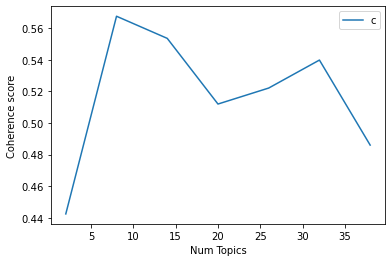

In [26]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"soscolombia" + 0.026*"video" + 0.016*"amp" + 0.012*"live" + '
  '0.011*"colombia" + 0.010*"world" + 0.010*"duque" + 0.010*"today" + '
  '0.010*"real" + 0.008*"show"'),
 (1,
  '0.057*"hacer" + 0.051*"poder" + 0.027*"mas" + 0.017*"politico" + '
  '0.015*"situacion" + 0.014*"creer" + 0.014*"problema" + 0.014*"igual" + '
  '0.013*"necesitar" + 0.013*"quedar"'),
 (2,
  '0.030*"estar" + 0.028*"paro" + 0.021*"dar" + 0.017*"favor" + 0.015*"despue" '
  '+ 0.014*"civil" + 0.014*"joven" + 0.013*"desaparecido" + 0.012*"ciudad" + '
  '0.011*"responder"'),
 (3,
  '0.072*"ver" + 0.042*"ir" + 0.041*"querer" + 0.032*"gente" + 0.030*"persona" '
  '+ 0.030*"solo" + 0.027*"si" + 0.016*"entonce" + 0.014*"mejor" + '
  '0.013*"dejar"'),
 (4,
  '0.053*"people" + 0.045*"police" + 0.040*"colombian" + 0.036*"protest" + '
  '0.031*"government" + 0.030*"kill" + 0.014*"violence" + 0.013*"shoot" + '
  '0.013*"protester" + 0.012*"stop"'),
 (5,
  '0.024*"country" + 0.016*"people" + 0.015*"make" + 0.011*